# This notebook is for the Fair-Shapely experiment

In [23]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [25]:
from src.data.unified_dataloader import load_dataset

a, processed_compas = load_dataset('compas')

In [26]:
processed_compas.head(3)

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,2.875313,-0.141855,-0.187414,-0.218065,-0.711240,0,0,0,0,0,1,1,0,1,0,1,0,0
1,1,-0.068808,-0.141855,-0.187414,-0.218065,-0.711240,1,0,0,0,0,0,1,0,1,0,1,0,1
2,1,-0.909985,-0.141855,-0.187414,1.775750,0.108063,1,0,0,0,0,0,1,0,1,0,1,0,1


### 3. Split label/unlabel data, split train/test data.

In [27]:
'''COMPAS'''
df = processed_compas.copy()
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (5049, 18)
X_test shape: (2165, 18)


### 4. Train the original model

In [28]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6609699769053118


In [29]:
X_train['sex'].value_counts()

sex
1    4060
0     989
Name: count, dtype: int64

In [30]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 1
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 0
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [31]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')

original_test_DR: 0.09081892669200897
original_train_DR: 0.0918121188879013


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

2. 初始化FairnessExplainer
--------接下来先对minority group进行修改--------
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用fairshap, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用fairshap, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
在X_train_minority中shapely value中大于0.1的值的个数有: 59
--------接下来对majority group进行修改--------
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
在X_train_majority中shapely value中大于0.1的值的个数有: 544
6. 开始整理minority部分的修改和majority部分的修改并且合并新数据,共修改603个数据点, 使用new training set训练新模型
changed_value_info.shape: 0


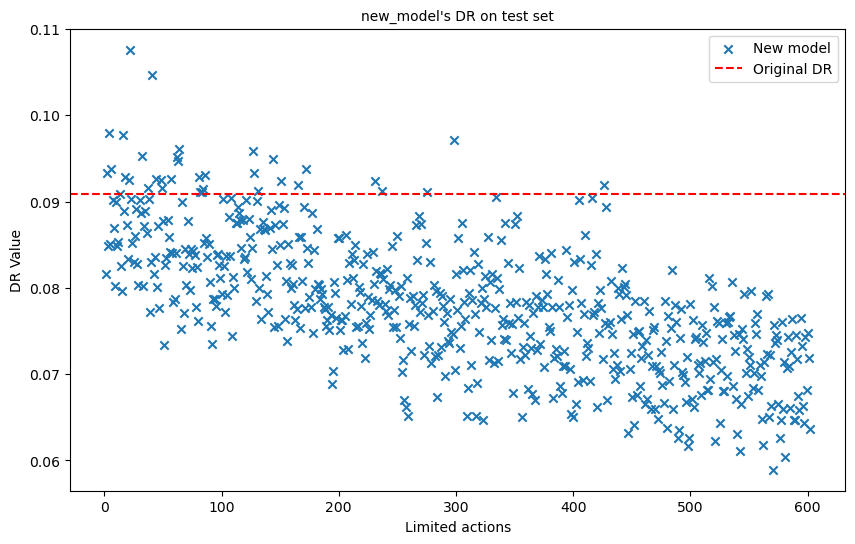

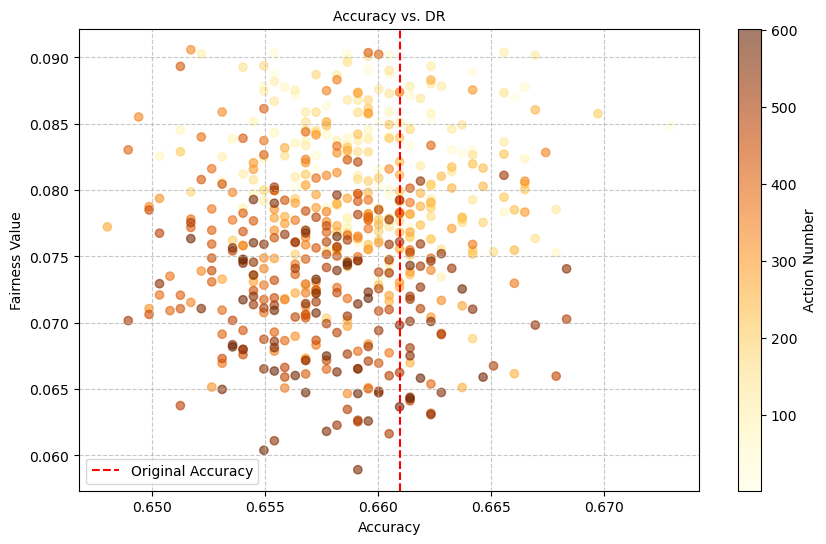

([0.08160933,
  0.09326549,
  0.08482128,
  0.09792851,
  0.08510366,
  0.093776785,
  0.09021439,
  0.08694753,
  0.08026025,
  0.08988856,
  0.08481897,
  0.085348025,
  0.09092686,
  0.08258008,
  0.07960987,
  0.097764395,
  0.08885601,
  0.09285227,
  0.08733446,
  0.08339316,
  0.09254279,
  0.10759249,
  0.09031389,
  0.08515698,
  0.083023146,
  0.086004764,
  0.089078985,
  0.08280125,
  0.08035406,
  0.09016052,
  0.0886914,
  0.09528421,
  0.08026597,
  0.08711264,
  0.08889968,
  0.086354226,
  0.0916111,
  0.09034383,
  0.07717849,
  0.08303891,
  0.104630314,
  0.08156592,
  0.08352601,
  0.09264617,
  0.08005815,
  0.087148696,
  0.07770611,
  0.092464015,
  0.09161652,
  0.08773256,
  0.07332325,
  0.082590215,
  0.083439365,
  0.087835506,
  0.08583466,
  0.084204935,
  0.09260503,
  0.08404024,
  0.07832792,
  0.07869423,
  0.08399153,
  0.0951895,
  0.09468185,
  0.09608204,
  0.07527488,
  0.08990303,
  0.08257021,
  0.07705103,
  0.08451628,
  0.080271624,
  0.0877

In [32]:
from src.experiments_approach4 import ExperimentNew4
''' 改变minority group中的部分特征值'''

experiment = ExperimentNew4(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas',)
experiment.run_experiment()


2. 初始化FairnessExplainer
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 238
shapely value中大于0.1的值的个数有: 149


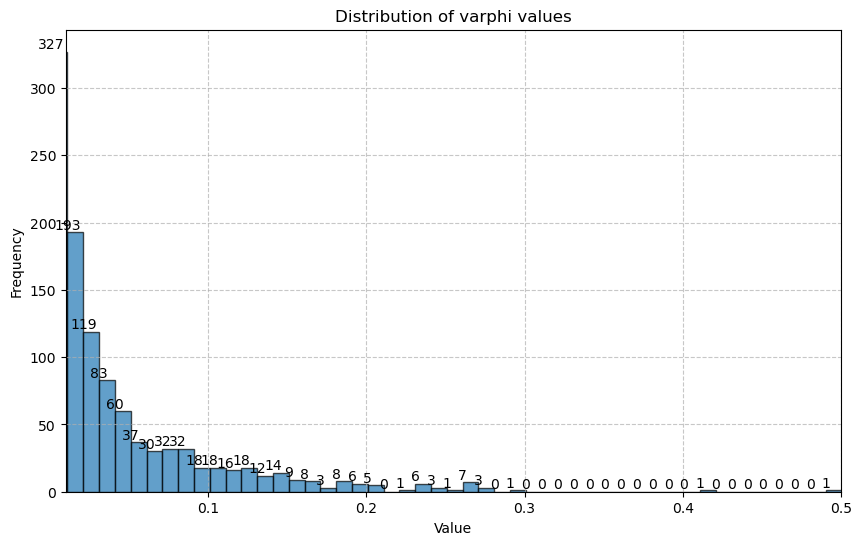

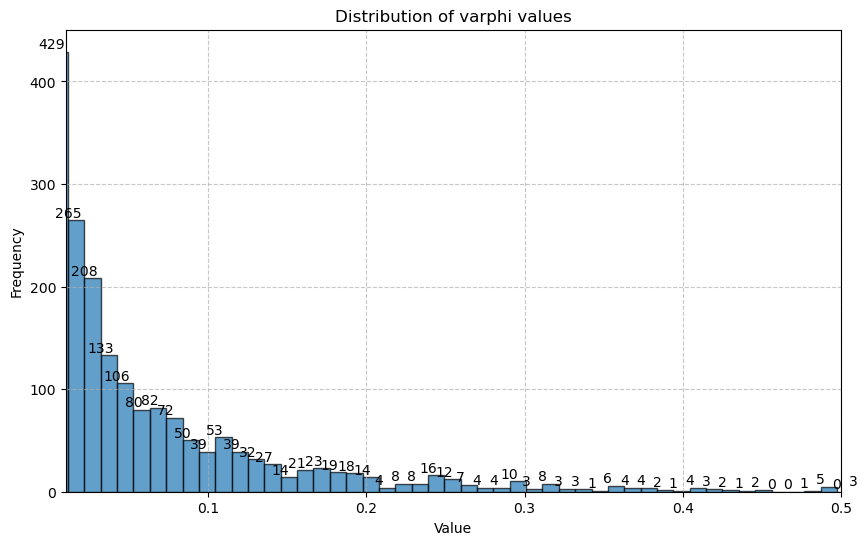

6. 开始整理并且合并新数据,共修改387个数据点, 使用new training set训练新模型
changed_value_info.shape: 386


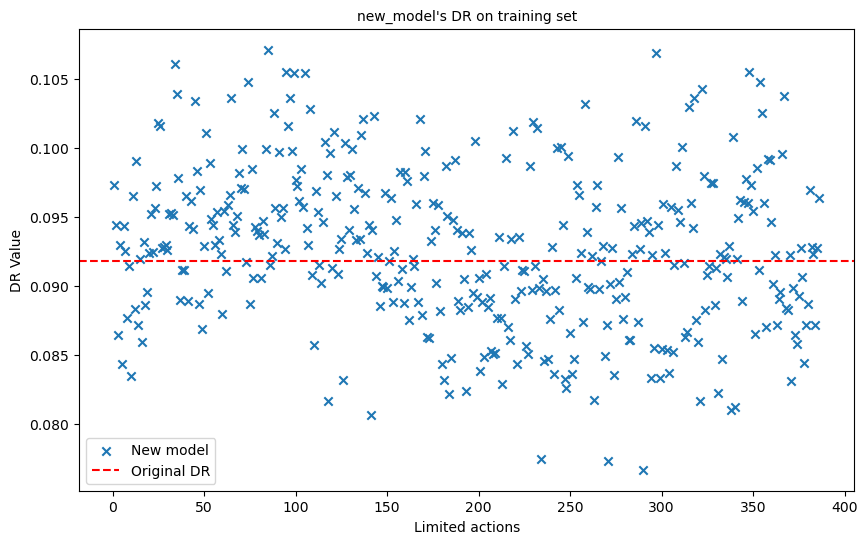

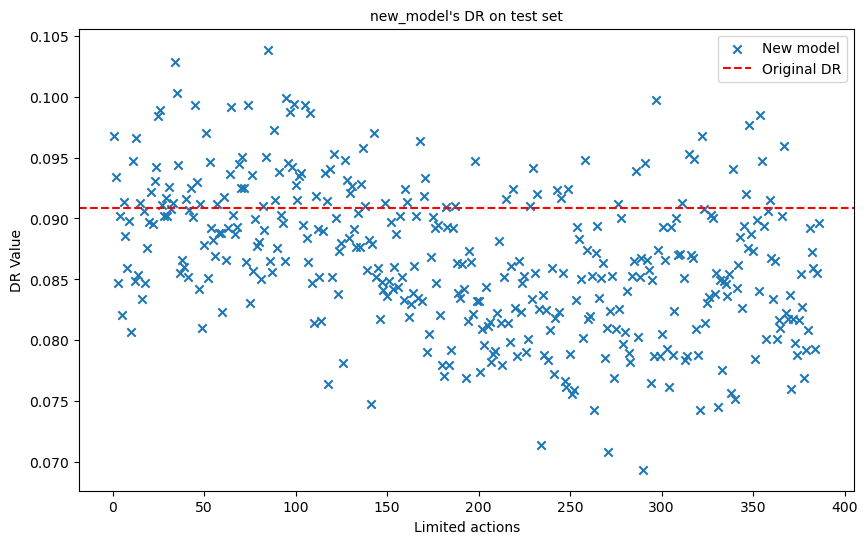

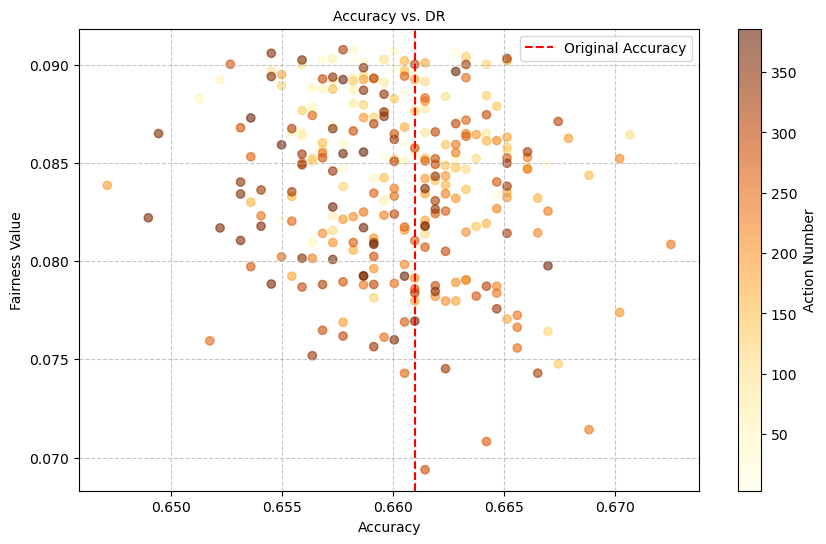

([0.096758,
  0.09341944,
  0.0846707,
  0.09017716,
  0.08206005,
  0.09133734,
  0.08859465,
  0.085970186,
  0.089804515,
  0.08065029,
  0.094700806,
  0.08488956,
  0.096622996,
  0.08538738,
  0.091237314,
  0.08337191,
  0.09064299,
  0.08473076,
  0.087559335,
  0.089670844,
  0.09214527,
  0.08955482,
  0.09304977,
  0.09421233,
  0.098395,
  0.09889272,
  0.09108547,
  0.09022576,
  0.09171162,
  0.09024078,
  0.092595,
  0.090748526,
  0.091297545,
  0.10285908,
  0.10028439,
  0.09442878,
  0.085493185,
  0.08656272,
  0.08600082,
  0.0916263,
  0.08522035,
  0.090676755,
  0.092523225,
  0.09011955,
  0.09934395,
  0.093032494,
  0.084209315,
  0.09117497,
  0.08097096,
  0.08783381,
  0.09704731,
  0.08507409,
  0.09460885,
  0.08922714,
  0.08825998,
  0.086886235,
  0.09115582,
  0.08877022,
  0.08883162,
  0.0822988,
  0.091731064,
  0.08657058,
  0.0891876,
  0.09363573,
  0.09912739,
  0.09030334,
  0.08871336,
  0.08931561,
  0.09443493,
  0.09249944,
  0.09505735,


In [22]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew2(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas',
                            change_group = 'majority')
experiment2.run_experiment()